# Import Packages

In [4]:
import numpy as np
import pandas as pd
import re, warnings, html, torch, umap, time, sys
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import normalize, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
from skopt import BayesSearchCV
from skopt.space import Categorical
from sklearn.base import BaseEstimator
from skopt.callbacks import DeltaYStopper, DeadlineStopper
from skopt.utils import point_asdict
from collections import deque
from transformers import AutoTokenizer, AutoModel

warnings.filterwarnings("ignore", category=UserWarning)

# Load Data

In [5]:
df_min_cleaned = pd.read_csv("min_cleaned_tweets.csv")
texts = df_min_cleaned["clean_text"].astype(str).tolist()

df_min_cleaned_sample = pd.read_csv("min_cleaned_sample_tweets.csv")

# CardiffNLP Twitter RoBERTa Sentiment

Classes: {'negative': 0, 'neutral': 1, 'positive': 2} | K_TRUE: 3
Using device: mps


Embedding: 100%|██████████| 229/229 [02:44<00:00,  1.39it/s]


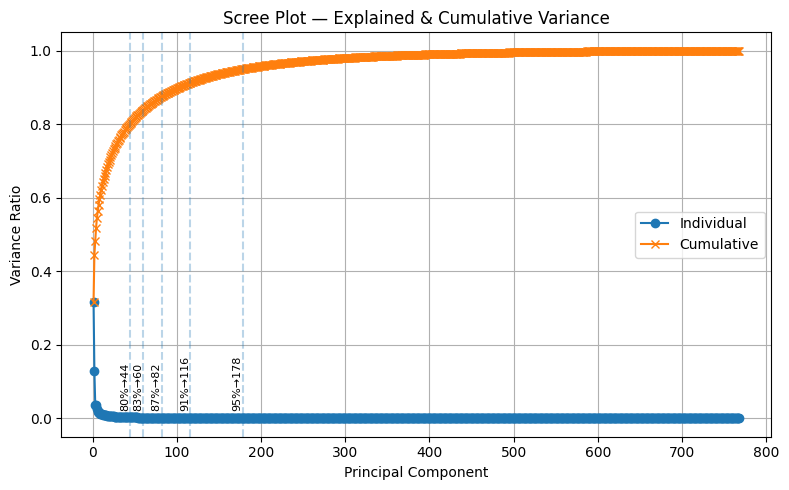

PCA n_components candidates (80–95% cum var): [44, 60, 82, 116, 178]

=== Running BayesSearchCV (PCA/UMAP × KMeans/GMM/Agglo) ===


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[Bayes] iter   4/60 ( 6.7%) | last  7.74s avg  7.74s | elapsed  0.1m ETA ~ 7.2m | branch pca+kmeans
[Bayes] iter   8/60 (13.3%) | last  6.98s avg  7.36s | elapsed  0.2m ETA ~ 6.4m | branch pca+kmeans
[Bayes] iter  12/60 (20.0%) | last  1.12s avg  5.28s | elapsed  0.3m ETA ~ 4.2m | branch pca+kmeans
[Bayes] iter  16/60 (26.7%) | last  1.51s avg  4.34s | elapsed  0.3m ETA ~ 3.2m | branch pca+kmeans
[Bayes] iter  20/60 (33.3%) | last  1.23s avg  3.72s | elapsed  0.3m ETA ~ 2.5m | branch pca+kmeans
[Bayes] iter  24/60 (40.0%) | last  1.48s avg  3.34s | elapsed  0.3m ETA ~ 2.0m | branch pca+kmeans
[Bayes] iter  28/60 (46.7%) | last  2.06s avg  3.16s | elapsed  0.4m ETA ~ 1.7m | branch pca+kmeans
[Bayes] iter  32/60 (53.3%) | last  2.10s avg  3.03s | elapsed  0.4m ETA ~ 1.4m | branch pca+kmeans
[Bayes] iter  36/60 (60.0%) | last  1.98s avg  2.91s | elapsed  0.4m ETA ~ 1.2m | branch pca+kmeans
[Bayes] iter  40/60 (66.7%) | last  2.17s avg  2.84s | elapsed  0.5m ETA ~ 0.9m | branch pca+kmeans


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[Bayes] iter   4/60 ( 6.7%) | last 24.22s avg  3.39s | elapsed  2.6m ETA ~ 3.2m | branch umap+kmeans


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[Bayes] iter   8/60 (13.3%) | last 18.88s avg  3.72s | elapsed  2.9m ETA ~ 3.2m | branch umap+kmeans
[Bayes] iter  12/60 (20.0%) | last 18.57s avg  4.03s | elapsed  3.2m ETA ~ 3.2m | branch umap+kmeans


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[Bayes] iter  16/60 (26.7%) | last 22.21s avg  4.40s | elapsed  3.6m ETA ~ 3.2m | branch umap+kmeans
[Bayes] iter  20/60 (33.3%) | last 18.70s avg  4.69s | elapsed  3.9m ETA ~ 3.1m | branch umap+kmeans
[Bayes] iter  24/60 (40.0%) | last 16.91s avg  4.93s | elapsed  4.2m ETA ~ 3.0m | branch umap+kmeans
[Bayes] iter  28/60 (46.7%) | last 19.72s avg  5.21s | elapsed  4.5m ETA ~ 2.8m | branch umap+kmeans
[Bayes] iter  32/60 (53.3%) | last 19.39s avg  5.48s | elapsed  4.8m ETA ~ 2.6m | branch umap+kmeans
[Bayes] iter  36/60 (60.0%) | last 22.85s avg  5.80s | elapsed  5.2m ETA ~ 2.3m | branch umap+kmeans
[Bayes] iter  40/60 (66.7%) | last 19.23s avg  6.05s | elapsed  5.5m ETA ~ 2.0m | branch umap+kmeans
[Bayes] iter  44/60 (73.3%) | last 20.64s avg  6.31s | elapsed  5.9m ETA ~ 1.7m | branch umap+kmeans
[Bayes] iter  48/60 (80.0%) | last 20.17s avg  6.55s | elapsed  6.2m ETA ~ 1.3m | branch umap+kmeans
[Bayes] iter  52/60 (86.7%) | last 21.87s avg  6.81s | elapsed  6.6m ETA ~ 0.9m | branch um

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,estimator,ClusteringPipeline()
,search_spaces,"[{'model': Categorical(c...), prior=None), 'n_components': Categorical(c...), prior=None), 'reducer': Categorical(c...), prior=None)}, {'cov_type': Categorical(c...), prior=None), 'model': Categorical(c...), prior=None), 'n_components': Categorical(c...), prior=None), 'reducer': Categorical(c...), prior=None)}, ...]"
,optimizer_kwargs,None
,n_iter,60
,scoring,None
,fit_params,None
,n_jobs,-1
,n_points,4
,iid,'deprecated'
,refit,True
,cv,"[(array([ 0, ...shape=(2928,)), ...)]"


In [6]:
# ---------------------------
# CONFIG
# ---------------------------
EMB_DIM = 768
RANDOM_STATE = 42

# ----------------------------------------------------------
# Load CardiffNLP tweet RoBERTa sentiment (no normalization)
# ----------------------------------------------------------
warnings.filterwarnings("ignore")
assert 'df_min_cleaned' in globals(), "Expected df_min_cleaned to be defined."
required = {'airline_sentiment','sentiment_confidence','clean_text'}
missing = required - set(df_min_cleaned.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df = df_min_cleaned.dropna(subset=['clean_text']).reset_index(drop=True).copy()

y_true_str = df['airline_sentiment'].astype(str).values
unique_true = {s:i for i,s in enumerate(sorted(pd.unique(y_true_str)))}
y_true = np.array([unique_true[s] for s in y_true_str], dtype=int)
K_TRUE = int(len(unique_true))
print("Classes:", unique_true, "| K_TRUE:", K_TRUE)

HF_MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"
MAX_LENGTH = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else ("mps" if getattr(torch.backends, 'mps', None) and torch.backends.mps.is_available() else "cpu"))
print("Using device:", DEVICE)

tok = AutoTokenizer.from_pretrained(HF_MODEL_NAME, use_fast=True)
enc_model = AutoModel.from_pretrained(HF_MODEL_NAME).to(DEVICE).eval()

def mean_pool(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    summed = (last_hidden_state * mask).sum(dim=1)
    counts = torch.clamp(mask.sum(dim=1), min=1e-9)
    return summed / counts

@torch.no_grad()
def embed_texts(batch_texts, batch_size=64):
    chunks = []
    for i in tqdm(range(0, len(batch_texts), batch_size), desc="Embedding"):
        b = batch_texts[i:i+batch_size]
        enc = tok(b, padding=True, truncation=True, max_length=MAX_LENGTH, return_tensors="pt")
        enc = {k:v.to(DEVICE) for k,v in enc.items()}
        out = enc_model(**enc)
        pooled = mean_pool(out.last_hidden_state, enc['attention_mask'])
        chunks.append(pooled.detach().cpu().numpy().astype("float32"))
        del enc, out, pooled
        if DEVICE.type == 'cuda':
            torch.cuda.empty_cache()
    return np.vstack(chunks)

def text_to_roberta_avg(sent, roberta, emb_dim=EMB_DIM):
    toks = [re.sub(r'^\W+|\W+$', '', t.lower()) for t in str(sent).split()]
    vecs = [roberta[t] for t in toks if t in roberta]
    if not vecs:
        return np.zeros(emb_dim, dtype=np.float32)
    return np.mean(vecs, axis=0).astype(np.float32)

def batch_embed(texts, roberta, emb_dim=EMB_DIM):
    return np.vstack([text_to_roberta_avg(s, roberta, emb_dim) for s in texts])

# ---------------------------
# Metrics
# ---------------------------
def hungarian_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    r, c = linear_sum_assignment(-cm)
    return cm[r, c].sum() / cm.sum()

def evaluate_full(X, y_true_int, labels, sil_metric):
    sil = silhouette_score(X, labels, metric=sil_metric)
    ari = adjusted_rand_score(y_true_int, labels)
    nmi = normalized_mutual_info_score(y_true_int, labels)
    acc = hungarian_accuracy(y_true_int, labels)
    return sil, ari, nmi, acc

# ---------------------------
# Prepare Data
# ---------------------------
texts_sample = df_min_cleaned_sample["clean_text"].astype(str).tolist()
texts_full   = df_min_cleaned["clean_text"].astype(str).tolist()

# Align labels from df (same row order)
le = LabelEncoder()
le.fit(df["airline_sentiment"].astype(str))
y_sample = le.transform(df.loc[df_min_cleaned_sample.index, "airline_sentiment"].astype(str))
y_full   = le.transform(df.loc[df_min_cleaned.index, "airline_sentiment"].astype(str))

# Compute HF embeddings (no normalization)
X_cardiff_sample = embed_texts(texts_sample)
X_cardiff_full = embed_texts(texts_full)


# ---------------------------
# PCA Scree Plot + pick 5 n_components (80–95% cum var, evenly spaced)
# ---------------------------
def pick_pca_candidates(X, pct_low=0.80, pct_high=0.95, k=5, max_components=None, plot=True):
    if max_components is None:
        max_components = min(EMB_DIM, X.shape[1])
    Xs   = StandardScaler().fit_transform(X)
    pca  = PCA(n_components=max_components, random_state=RANDOM_STATE)
    pca.fit(Xs)
    evr  = pca.explained_variance_ratio_
    cum  = np.cumsum(evr)

    thresholds = np.linspace(pct_low, pct_high, k)
    comps = []
    for t in thresholds:
        idx = int(np.argmax(cum >= t)) + 1
        comps.append(idx)

    # dedupe while preserving order
    seen = set(); comps_unique = []
    for c in comps:
        if c not in seen:
            comps_unique.append(c); seen.add(c)

    # ensure exactly k values (best-effort padding)
    while len(comps_unique) < k:
        step = max(1, (comps_unique[-1] - comps_unique[0]) // (k-1))
        candidate = min(max_components, comps_unique[-1] + step)
        if candidate not in seen:
            comps_unique.append(candidate); seen.add(candidate)
        else:
            candidate = min(max_components, candidate+1)
            if candidate not in seen:
                comps_unique.append(candidate); seen.add(candidate)
            else:
                break

    comps_unique = sorted(comps_unique)[:k]

    if plot:
        xs = np.arange(1, len(evr)+1)
        plt.figure(figsize=(8,5))
        plt.plot(xs, evr, marker='o', label='Individual')
        plt.plot(xs, cum, marker='x', label='Cumulative')
        for t, c in zip(thresholds, comps):
            plt.axvline(c, linestyle='--', alpha=0.3)
            plt.text(c, 0.02, f'{int(t*100)}%→{c}', rotation=90, va='bottom', ha='right', fontsize=8)
        plt.title('Scree Plot — Explained & Cumulative Variance')
        plt.xlabel('Principal Component'); plt.ylabel('Variance Ratio')
        plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    return comps_unique, cum

pca_candidates, _cum = pick_pca_candidates(
    X_cardiff_sample, pct_low=0.80, pct_high=0.95, k=5, max_components=EMB_DIM, plot=True
)
print("PCA n_components candidates (80–95% cum var):", pca_candidates)

# Fixed UMAP candidate grids (your choices)
umap_neighbors  = [15, 30, 45, 60, 75, 100, 150, 200]
umap_min_dist   = [0.1, 0.2, 0.3, 0.4, 0.5]
umap_components = [16, 32, 48, 64, 96, 128]

# ---------------------------
# ClusteringPipeline class (for BayesSearchCV)
# ---------------------------
_LAST_TRIAL = deque(maxlen=1)

class ClusteringPipeline(BaseEstimator):
    def __init__(self,
                 reducer='pca', n_components=50,
                 n_neighbors=15, min_dist=0.1, n_components_umap=16,
                 model='kmeans', cov_type='full', linkage='average'):
        self.reducer = reducer
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.min_dist = min_dist
        self.n_components_umap = n_components_umap
        self.model = model
        self.cov_type = cov_type
        self.linkage = linkage

    def fit(self, X, y=None):
        # record the params actually used (for robust logging)
        _LAST_TRIAL.clear()
        _LAST_TRIAL.append({
            'reducer'          : self.reducer,
            'n_components'     : self.n_components,
            'n_neighbors'      : self.n_neighbors,
            'min_dist'         : self.min_dist,
            'n_components_umap': self.n_components_umap,
            'model'            : self.model,
            'cov_type'         : self.cov_type,
            'linkage'          : self.linkage,
        })
        # ---------------- Reducer ----------------
        if self.reducer == 'pca':
            X_std = StandardScaler().fit_transform(X)
            X_red = PCA(n_components=self.n_components, random_state=RANDOM_STATE).fit_transform(X_std)
        else:
            X_l2 = normalize(X)
            X_red = umap.UMAP(
                n_neighbors=self.n_neighbors,
                min_dist=self.min_dist,
                n_components=self.n_components_umap,
                metric='cosine',
                random_state=RANDOM_STATE,
                n_epochs=120,
                low_memory=True
            ).fit_transform(X_l2)

        # ---------------- Clustering ----------------
        if self.model == 'kmeans':
            X_use = normalize(X_red)
            labels = KMeans(n_clusters=3, n_init=10, algorithm='elkan', random_state=RANDOM_STATE).fit_predict(X_use)
            self.metric = "cosine"
        elif self.model == 'gmm':
            X_use = np.asarray(X_red, dtype=np.float64)
            try:
                labels = GaussianMixture(
                    n_components=3, n_init=10, random_state=RANDOM_STATE,
                    covariance_type=self.cov_type
                ).fit_predict(X_use)
            except ValueError:
                labels = GaussianMixture(
                    n_components=3, n_init=10, random_state=RANDOM_STATE,
                    covariance_type=self.cov_type, reg_covar=1e-5
                ).fit_predict(X_use)
            self.metric = "euclidean"
        else:  # Agglo
            X_use = normalize(X_red)
            labels = AgglomerativeClustering(
                n_clusters=3, linkage=self.linkage, metric='cosine'
            ).fit_predict(X_use)
            self.metric = "cosine"

        # store for score()
        self.labels_ = labels
        self.X_use_  = X_use
        self.score_  = silhouette_score(X_use, labels, metric=self.metric)
        return self

    def score(self, X, y=None):
        return self.score_

# ---------------------------
# Bayesian Search Space 
# ---------------------------
search_spaces = [
    # PCA + KMeans
    {
        'reducer'      : Categorical(['pca'],        name='reducer'),
        'n_components' : Categorical(pca_candidates, name='n_components'),
        'model'        : Categorical(['kmeans'],     name='model'),
    },
    # PCA + GMM
    {
        'reducer'      : Categorical(['pca'],        name='reducer'),
        'n_components' : Categorical(pca_candidates, name='n_components'),
        'model'        : Categorical(['gmm'],        name='model'),
        'cov_type'     : Categorical(['full','tied','diag','spherical'], name='cov_type'),
    },
    # PCA + Agglo (no 'ward' since metric='cosine')
    {
        'reducer'      : Categorical(['pca'],        name='reducer'),
        'n_components' : Categorical(pca_candidates, name='n_components'),
        'model'        : Categorical(['agglo'],      name='model'),
        'linkage'      : Categorical(['average','complete','single'], name='linkage'),
    },

    # UMAP + KMeans
    {
        'reducer'           : Categorical(['umap'],  name='reducer'),
        'n_neighbors'       : Categorical(umap_neighbors,  name='n_neighbors'),
        'min_dist'          : Categorical(umap_min_dist,   name='min_dist'),
        'n_components_umap' : Categorical(umap_components, name='n_components_umap'),
        'model'             : Categorical(['kmeans'],      name='model'),
    },
    # UMAP + GMM
    {
        'reducer'           : Categorical(['umap'],  name='reducer'),
        'n_neighbors'       : Categorical(umap_neighbors,  name='n_neighbors'),
        'min_dist'          : Categorical(umap_min_dist,   name='min_dist'),
        'n_components_umap' : Categorical(umap_components, name='n_components_umap'),
        'model'             : Categorical(['gmm'],         name='model'),
        'cov_type'          : Categorical(['full','tied','diag','spherical'], name='cov_type'),
    },
    # UMAP + Agglo
    {
        'reducer'           : Categorical(['umap'],  name='reducer'),
        'n_neighbors'       : Categorical(umap_neighbors,  name='n_neighbors'),
        'min_dist'          : Categorical(umap_min_dist,   name='min_dist'),
        'n_components_umap' : Categorical(umap_components, name='n_components_umap'),
        'model'             : Categorical(['agglo'],       name='model'),
        'linkage'           : Categorical(['average','complete','single'], name='linkage'),
    },
]

# --- progress/timing callback for BayesSearchCV (with robust fallback) ---
TOTAL_ITERS = 60  # keep in sync with BayesSearchCV(n_iter=...)

_timings = []
_start = [None]
_prev  = [None]

def _short_params(d):
    keys = [
        'reducer','n_components','n_neighbors','min_dist','n_components_umap',
        'model','cov_type','linkage'
    ]
    return {k: d[k] for k in keys if k in d}

def _infer_branch_from_space(space):
    """Infer branch name (reducer+model) from single-choice categories in subspace."""
    reducer = model = None
    for dim in getattr(space, "dimensions", []):
        cats = getattr(dim, "categories", None)
        if not cats or not hasattr(cats, "__iter__"):
            continue
        if len(cats) == 1:
            v = cats[0]
            if v in ("pca", "umap"):
                reducer = v
            elif v in ("kmeans", "gmm", "agglo"):
                model = v
    return f"{reducer or '?'}+{model or '?'}"

def progress_callback(res):
    import time, numpy as np
    now = time.perf_counter()
    if _start[0] is None:
        _start[0] = now
    if _prev[0] is not None:
        _timings.append(now - _prev[0])

    k = len(res.x_iters)
    avg = float(np.mean(_timings)) if _timings else 0.0
    elapsed = now - _start[0]
    remaining = max(TOTAL_ITERS - k, 0) * (avg if avg > 0 else 0.0)

    # Try to get the reducer/model from the latest evaluated point
    branch = None
    try:
        if res.x_iters:
            last_params = point_asdict(res.space, res.x_iters[-1])
            r, m = last_params.get("reducer"), last_params.get("model")
            if r and m:
                branch = f"{r}+{m}"
    except Exception:
        pass

    # Fallback: infer directly from this subspace definition
    if branch is None:
        branch = _infer_branch_from_space(res.space)

    last_dt = _timings[-1] if _timings else 0.0
    print(
        f"[Bayes] iter {k:>3}/{TOTAL_ITERS} ({k/TOTAL_ITERS:5.1%}) "
        f"| last {last_dt:5.2f}s avg {avg:5.2f}s "
        f"| elapsed {elapsed/60:4.1f}m ETA ~{remaining/60:4.1f}m "
        f"| branch {branch}",
        flush=True
    )
    _prev[0] = now
    return False

# ---------------------------
# Run Bayesian SearchCV
# ---------------------------
n = X_cardiff_sample.shape[0]
dummy_y = np.zeros(n, dtype=int)
cv_full = [(np.arange(n), np.arange(n))]

search = BayesSearchCV(
    estimator=ClusteringPipeline(),
    search_spaces=search_spaces,           # <-- your original list-of-branches
    n_iter=TOTAL_ITERS,
    random_state=RANDOM_STATE,
    scoring=None,                          # uses estimator.score() (silhouette)
    cv=cv_full,
    n_points=4,                            # parallel proposals
    n_jobs=-1,                             # parallel fits
    return_train_score=False
)

print("\n=== Running BayesSearchCV (PCA/UMAP × KMeans/GMM/Agglo) ===")
callbacks = [
    DeltaYStopper(delta=1e-4, n_best=15),
    progress_callback
]

# prime timers for clean first measurement
_prev[0] = time.perf_counter()
_start[0] = _prev[0]

search.fit(X_cardiff_sample, dummy_y, callback=callbacks)

In [7]:
# ==========================================================
# Final (Full-Data) ClusteringPipeline — no speed tweaks
# ==========================================================
class ClusteringPipeline(BaseEstimator):
    def __init__(self,
                 reducer='pca', n_components=50,
                 n_neighbors=15, min_dist=0.1, n_components_umap=16,
                 model='kmeans', cov_type='full', linkage='average'):
        self.reducer = reducer
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.min_dist = min_dist
        self.n_components_umap = n_components_umap
        self.model = model
        self.cov_type = cov_type
        self.linkage = linkage

    def fit(self, X, y=None):
        if self.reducer == 'pca':
            X_std = StandardScaler().fit_transform(X)
            X_red = PCA(n_components=self.n_components, random_state=RANDOM_STATE).fit_transform(X_std)
        else:
            X_l2 = normalize(X)
            X_red = umap.UMAP(
                n_neighbors=self.n_neighbors,
                min_dist=self.min_dist,
                n_components=self.n_components_umap,
                metric='cosine',
                random_state=RANDOM_STATE
            ).fit_transform(X_l2)

        if self.model == 'kmeans':
            X_use = normalize(X_red)
            labels = KMeans(n_clusters=3, n_init=10, algorithm='elkan',
                            random_state=RANDOM_STATE).fit_predict(X_use)
            self.metric = "cosine"
        elif self.model == 'gmm':
            X_use = np.asarray(X_red, dtype=np.float64)
            try:
                labels = GaussianMixture(
                    n_components=3, n_init=10, random_state=RANDOM_STATE,
                    covariance_type=self.cov_type
                ).fit_predict(X_use)
            except ValueError:
                labels = GaussianMixture(
                    n_components=3, n_init=10, random_state=RANDOM_STATE,
                    covariance_type=self.cov_type, reg_covar=1e-5
                ).fit_predict(X_use)
            self.metric = "euclidean"
        else:  # Agglomerative
            X_use = normalize(X_red)
            labels = AgglomerativeClustering(
                n_clusters=3, linkage=self.linkage, metric='cosine'
            ).fit_predict(X_use)
            self.metric = "cosine"

        self.labels_ = labels
        self.X_use_ = X_use
        self.score_ = silhouette_score(X_use, labels, metric=self.metric)
        return self

    def score(self, X, y=None):
        return self.score_


# ==========================================================
# Extract best per-branch on 20% subset
# ==========================================================
def _params_compact(d):
    order = ["reducer","model","n_components",
             "n_neighbors","min_dist","n_components_umap",
             "cov_type","linkage"]
    return ", ".join(f"{k}={d[k]}" for k in order if k in d and pd.notnull(d[k]))

cv = pd.DataFrame(search.cv_results_)
param_cols = [c for c in cv.columns if c.startswith("param_")]
score_col  = "mean_test_score"  # silhouette

# Ensure plain Python types
for c in param_cols:
    cv[c] = cv[c].apply(lambda x: x if isinstance(x, (str,int,float,type(None))) else str(x))

cv["branch"] = cv.apply(lambda r: f"{r.get('param_reducer','?')}+{r.get('param_model','?')}", axis=1)
best_idx = cv.groupby("branch")[score_col].idxmax()
best_rows = cv.loc[best_idx].reset_index(drop=True)

subset_records = []
for _, r in best_rows.iterrows():
    params = {p.replace("param_",""): r[p] for p in param_cols if pd.notnull(r[p])}
    subset_records.append({
        "branch": r["branch"],
        "best_sil_subset": round(float(r[score_col]), 4),
        **params
    })

df_best_subset = pd.DataFrame(subset_records).sort_values("branch")

print("\n================ Best Parameters per Branch (20% subset) ================\n")
print(df_best_subset[[
    "branch","best_sil_subset","reducer","model","n_components",
    "n_neighbors","min_dist","n_components_umap","cov_type","linkage"
]].to_string(index=False))


# ==========================================================
# Refit each best branch on FULL data + compute metrics
# ==========================================================
final_rows = []
for _, row in df_best_subset.iterrows():
    params = {}
    for k in ["reducer","model","n_components","n_neighbors","min_dist",
              "n_components_umap","cov_type","linkage"]:
        if k in row and pd.notnull(row[k]):
            val = row[k]
            if k in ["n_components","n_neighbors","n_components_umap"] and not pd.isna(val):
                val = int(val)
            if k == "min_dist" and not pd.isna(val):
                val = float(val)
            params[k] = val

    mdl = ClusteringPipeline(**params)
    mdl.fit(X_cardiff_full)
    labels = mdl.labels_
    metric = getattr(mdl, "metric", "cosine")
    sil, ari, nmi, acc = evaluate_full(mdl.X_use_, y_full, labels, metric)

    final_rows.append({
        "branch": row["branch"],
        "Silhouette": round(sil, 3),
        "ARI": round(ari, 3),
        "NMI": round(nmi, 3),
        "Hungarian": round(acc, 3),
        "Params": _params_compact(params)
    })

df_final = pd.DataFrame(final_rows).sort_values("branch")

print("\n================ Final Evaluation on Full Minimal-Cleaned Data (All 6 best models) ================\n")
print(df_final[["branch","Silhouette","ARI","NMI","Hungarian","Params"]].to_string(index=False))


# ==========================================================
# Quick metric winners
# ==========================================================
for metric in ["Silhouette","ARI","NMI","Hungarian"]:
    r = df_final.loc[df_final[metric].idxmax()]
    print(f"\nWinner by {metric}: {r['branch']} | {metric}={r[metric]:.3f} | {r['Params']}")


================ Best Parameters per Branch (20% subset) ================

     branch  best_sil_subset reducer  model  n_components  n_neighbors  min_dist  n_components_umap cov_type linkage
  pca+agglo           0.3145     pca  agglo          82.0          NaN       NaN                NaN      NaN average
    pca+gmm           0.2539     pca    gmm          44.0          NaN       NaN                NaN     tied     NaN
 pca+kmeans           0.4006     pca kmeans          44.0          NaN       NaN                NaN      NaN     NaN
 umap+agglo           0.7171    umap  agglo           NaN        200.0       0.1               32.0      NaN average
   umap+gmm           0.5293    umap    gmm           NaN        200.0       0.1               48.0     full     NaN
umap+kmeans           0.7279    umap kmeans           NaN        200.0       0.1               32.0      NaN     NaN

================ Final Evaluation on Full Minimal-Cleaned Data (All 6 best models) ================

   